In [17]:
import numpy as np
# np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
import lightgbm as lgb

In [2]:

n_estimator = 10
# 生成样本集，二分类样本生成
X, y = make_classification(n_samples=80000, n_features=20)
# 将样本集分成测试集和训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# 再将训练集拆成两个部分（GBDT/RF，LR）
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)

In [3]:
# 基于随机森林的监督变换 rf+lr （特征数量越多，喂给LR的特征越多，参数量越大 => 理论上模型的上限越高）
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [4]:
# 得到OneHot编码
rf_enc = OneHotEncoder(categories='auto')
rf_enc.fit(rf.apply(X_train)) 

OneHotEncoder()

In [5]:
# 使用OneHot编码作为特征，训练LR
rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)

In [6]:
# GBDT 将原始的20维特征 => 2万特征
temp = rf.apply(X_train_lr)
print('temp=\n', temp)
print('len(temp[0])=', len(temp[0]))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

temp=
 [[ 7 13 11 ... 10 13 14]
 [ 6 13 11 ... 11 13 14]
 [ 6 14 10 ...  4 11  4]
 ...
 [ 7 14 11 ... 10 13 14]
 [ 4  4 11 ... 13  7 14]
 [ 3 11 11 ...  6 13 10]]
len(temp[0])= 10


LogisticRegression(max_iter=1000)

In [7]:
# 使用LR进行预测
# Step1，先进行RF => onehot
# Step2，把生成的特征 onehot 进行LR预测
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

In [8]:
# 基于GBDT监督变换，gbdt+lr
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(X_train, y_train) # 前两万个样本
# 得到OneHot编码
grd_enc = OneHotEncoder(categories='auto')

In [9]:
grd_enc.fit(grd.apply(X_train)[:, :, 0])
#print(grd_enc.get_feature_names()) # 查看每一列对应的特征
# 使用OneHot编码作为特征，训练LR
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

LogisticRegression(max_iter=1000)

In [19]:
# 使用Light-GBM
# 创建成lgb特征的数据集格式
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
 
# 将参数写成字典下形式
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 31,  # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9,  # 建树的特征选择比例
    'bagging_fraction': 0.8,  # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
 
# 训练 cv and train
gbm = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_eval, early_stopping_rounds=5)
 
# 预测数据集
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# y_pred_lgbm = lgb.

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 20
[LightGBM] [Info] Start training from score 0.499350
[1]	valid_0's auc: 0.964007	valid_0's l2: 0.231339
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.966818	valid_0's l2: 0.214373
[3]	valid_0's auc: 0.96888	valid_0's l2: 0.198993
[4]	valid_0's auc: 0.969108	valid_0's l2: 0.185265
[5]	valid_0's auc: 0.96993	valid_0's l2: 0.172693
[6]	valid_0's auc: 0.971322	valid_0's l2: 0.161342
[7]	valid_0's auc: 0.971607	valid_0's l2: 0.15109
[8]	valid_0's auc: 0.971679	valid_0's l2: 0.141902
[9]	valid_0's auc: 0.971761	valid_0's l2: 0.133558
[10]	valid_0's auc: 0.971801	valid_0's l2: 0.126035
[11]	valid_0's auc: 0.972807	valid_0's l2: 0.11921
[12]	valid_0's auc: 0.972988	valid_0

In [10]:
# 使用LR进行预测
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

In [11]:
# 直接使用GBDT进行预测
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

In [12]:
# 直接使用RF进行预测
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_skl = roc_curve(y_test, y_pred_rf)

In [13]:
# 直接使用LR进行预测
LR = LogisticRegression(n_jobs=4, C=0.1, penalty='l2')
LR.fit(X_train, y_train)
y_pred = LR.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)

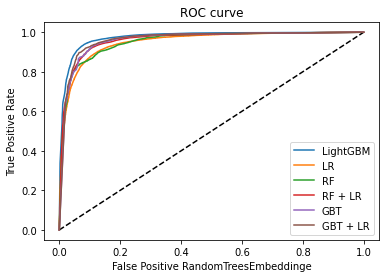

In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive RandomTreesEmbeddinge')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

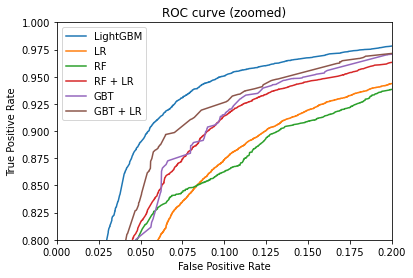

In [21]:
# 将左上角放大显示
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()